In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
TRAIN_DATA = '/content/drive/MyDrive/временные ряды/train.csv'

In [ ]:
data = pd.read_csv(TRAIN_DATA)

data.tail()

,Date,store,product,number_sold
230085,2018-12-27,6,9,890
230086,2018-12-28,6,9,892
230087,2018-12-29,6,9,895
230088,2018-12-30,6,9,899
230089,2018-12-31,6,9,912


# 1. Анализ данных и удаление выбросов



In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

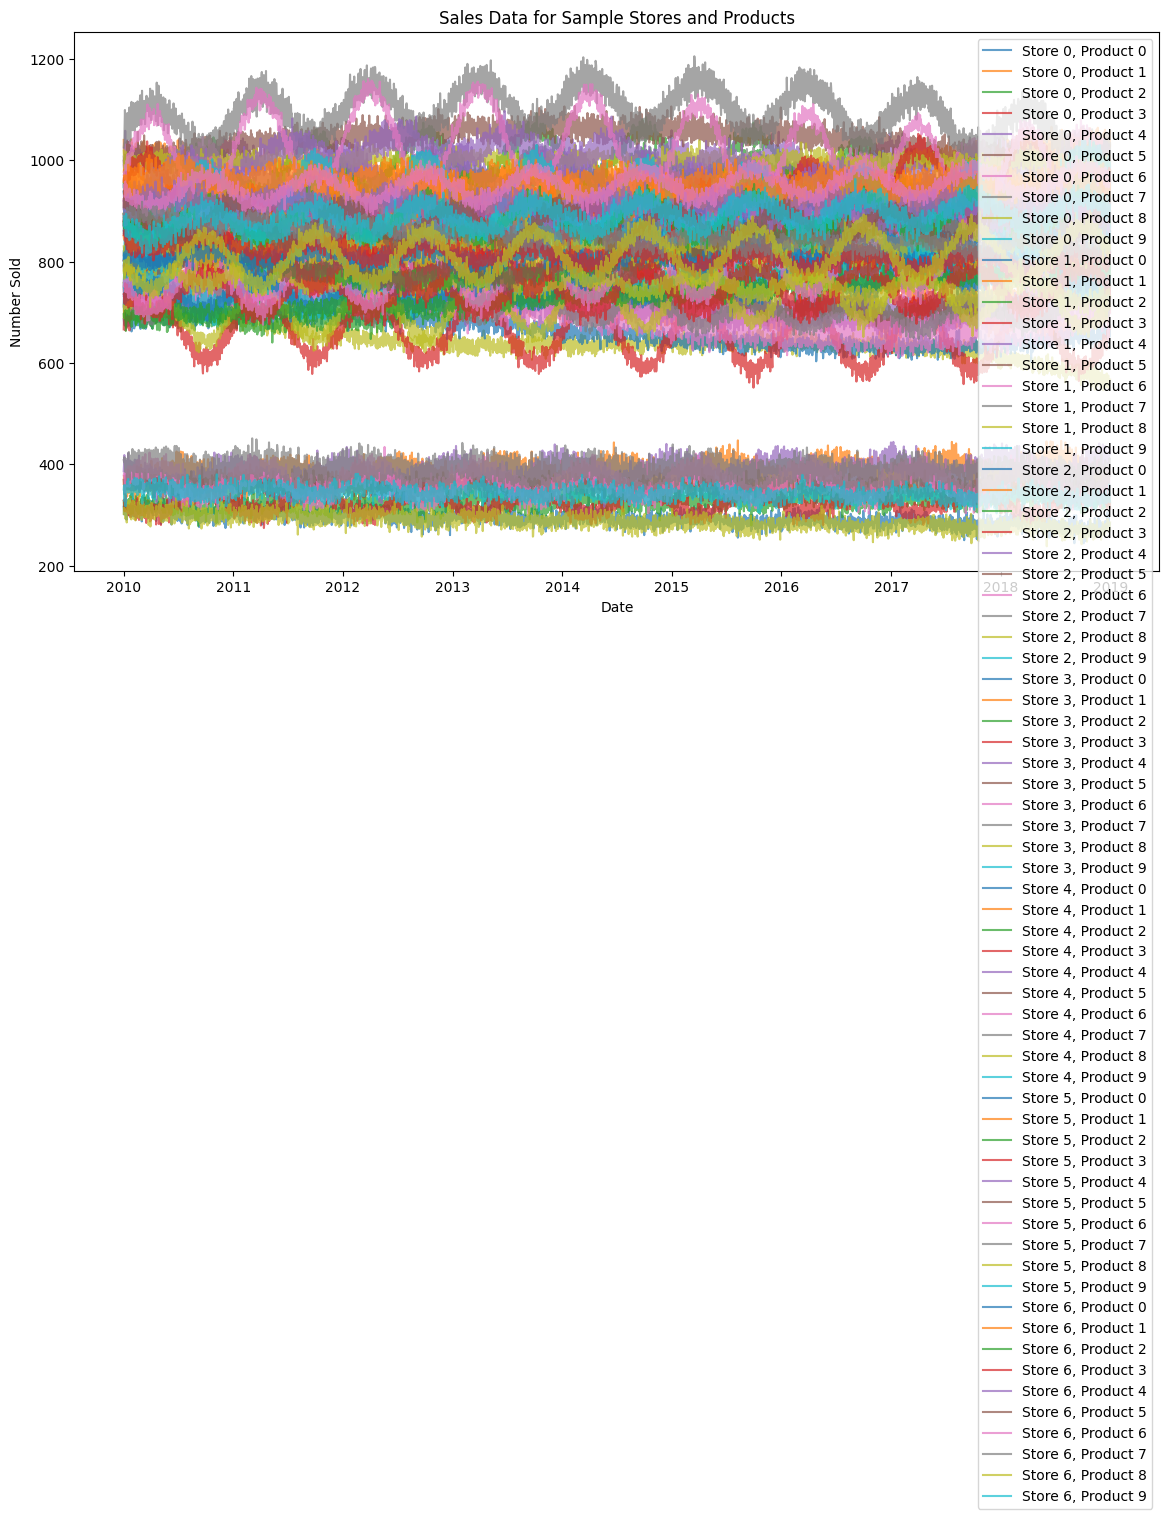

In [ ]:
#смотрим данные по всем продуктам и магазинам
plt.figure(figsize=(14, 7))
for store_id in data['store'].unique():
    for product_id in data['product'].unique():
        subset = data[(data['store'] == store_id) & (data['product'] == product_id)]
        plt.plot(subset['Date'], subset['number_sold'], label=f'Store {store_id}, Product {product_id}', alpha=0.7)

plt.title('Sales Data for Sample Stores and Products')
plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.legend(loc='upper right')
plt.show()

In [ ]:
#группируем данные по дате с удалением колонок id продукта и магазина
grouped_data = data.groupby('Date')['number_sold'].sum().reset_index()
data['Date'] = pd.to_datetime(data['Date'])

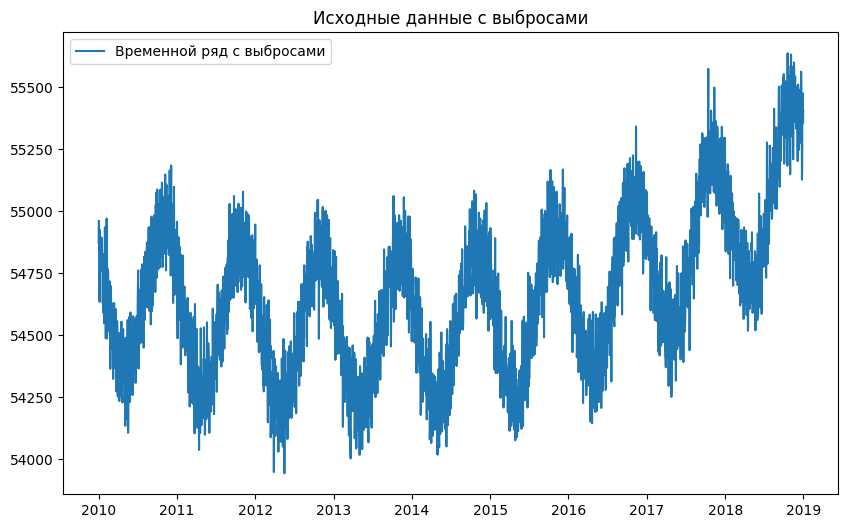

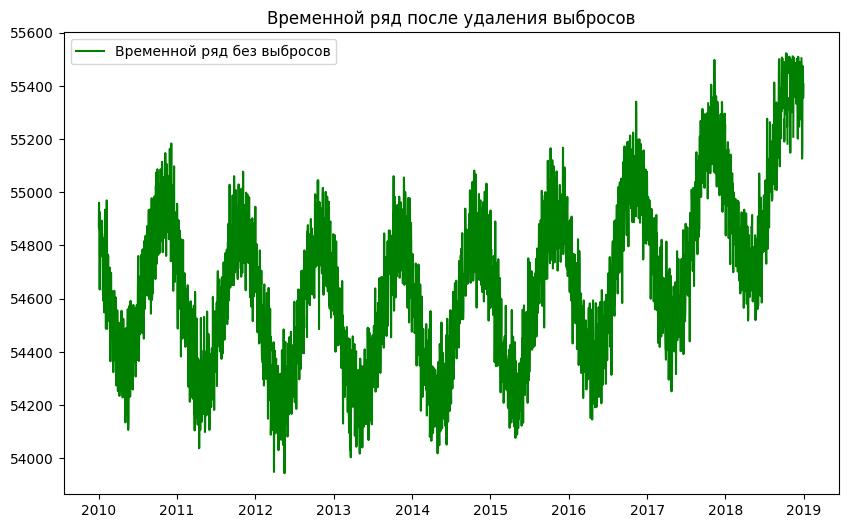

Размер данных до очистки: 3287
Размер данных после очистки: 3270


In [ ]:
# Визуализация исходных данных с выбросами
plt.figure(figsize=(10, 6))
plt.plot(grouped_data.Date, grouped_data.number_sold, label='Временной ряд с выбросами')
plt.title("Исходные данные с выбросами")
plt.legend()
plt.show()

# Функция для удаления выбросов
def remove_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    # Границы для выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Фильтрация выбросов
    filtered_series = series[(series >= lower_bound) & (series <= upper_bound)]

    return filtered_series

# Применение функции для удаления выбросов
cleaned_data = remove_outliers(grouped_data)

# Визуализация очищенных данных без выбросов
plt.figure(figsize=(10, 6))
plt.plot(cleaned_data.Date, cleaned_data.number_sold, label='Временной ряд без выбросов', color='green')
plt.title("Временной ряд после удаления выбросов")
plt.legend()
plt.show()

# Сравнение до и после
print(f"Размер данных до очистки: {len(grouped_data)}")
print(f"Размер данных после очистки: {cleaned_data['number_sold'].notnull().sum()}")

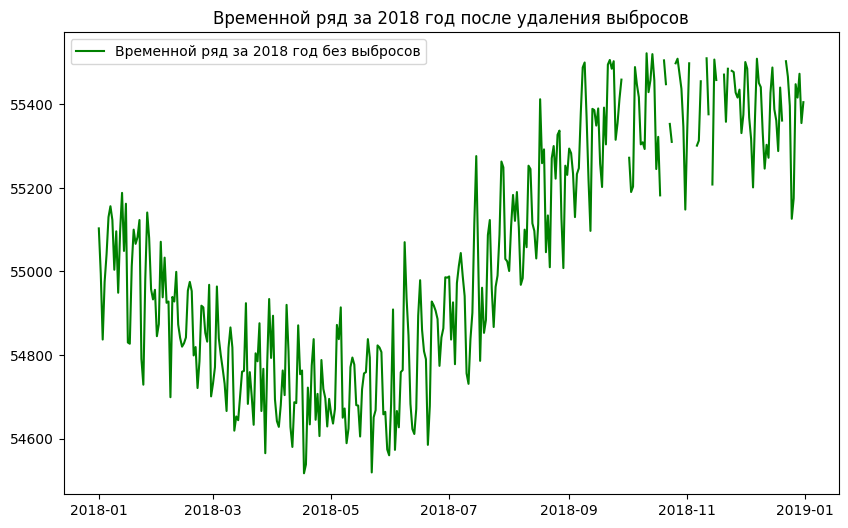

In [ ]:
# Посмотрим на тренд внутри года
data_2018 = cleaned_data[cleaned_data['Date'].dt.year == 2018]

# Визуализация данных за 2018 год
plt.figure(figsize=(10, 6))
plt.plot(data_2018.Date, data_2018.number_sold, label='Временной ряд за 2018 год без выбросов', color='green')
plt.title("Временной ряд за 2018 год после удаления выбросов")
plt.legend()
plt.show()

- На графике явно видна сезонность. Продажи демонстрируют повторяющиеся пики и спады каждый год, что указывает на циклический характер данных.
- В пределах одного года заметны колебания, зависящие от сезона (спад в летнее время и подъем продаж к началу зимы).
- Есть плавное увеличение общего уровня продаж.
- В данных нет выбросов, которые стоило бы удалить (их немного и они связаны с реальными продажами).

In [ ]:
grouped_data.set_index('Date', inplace = True)
grouped_data

,number_sold
Date,
2010-01-01,54870
2010-01-02,54960
2010-01-03,54863
2010-01-04,54926
2010-01-05,54634
...,...
2018-12-27,55448
2018-12-28,55416
2018-12-29,55473


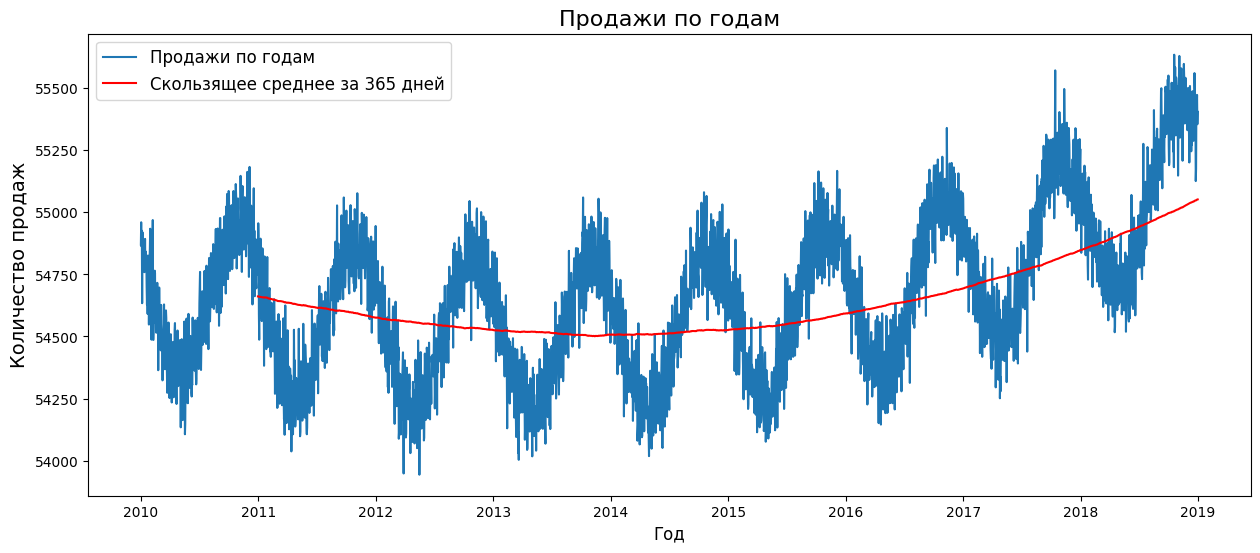

In [ ]:
#скользящее среднее для дополнительной оценки тренда
plt.figure(figsize = (15, 6))

plt.plot(grouped_data, label = 'Продажи по годам')
plt.plot(grouped_data.rolling(window = 365).mean(), label = 'Скользящее среднее за 365 дней', color = 'red')


plt.legend(title = '', loc = 'upper left', fontsize = 12)
plt.xlabel('Год', fontsize = 12)
plt.ylabel('Количество продаж', fontsize = 14)
plt.title('Продажи по годам', fontsize = 16)

# выведем обе кривые на одном графике
plt.show()

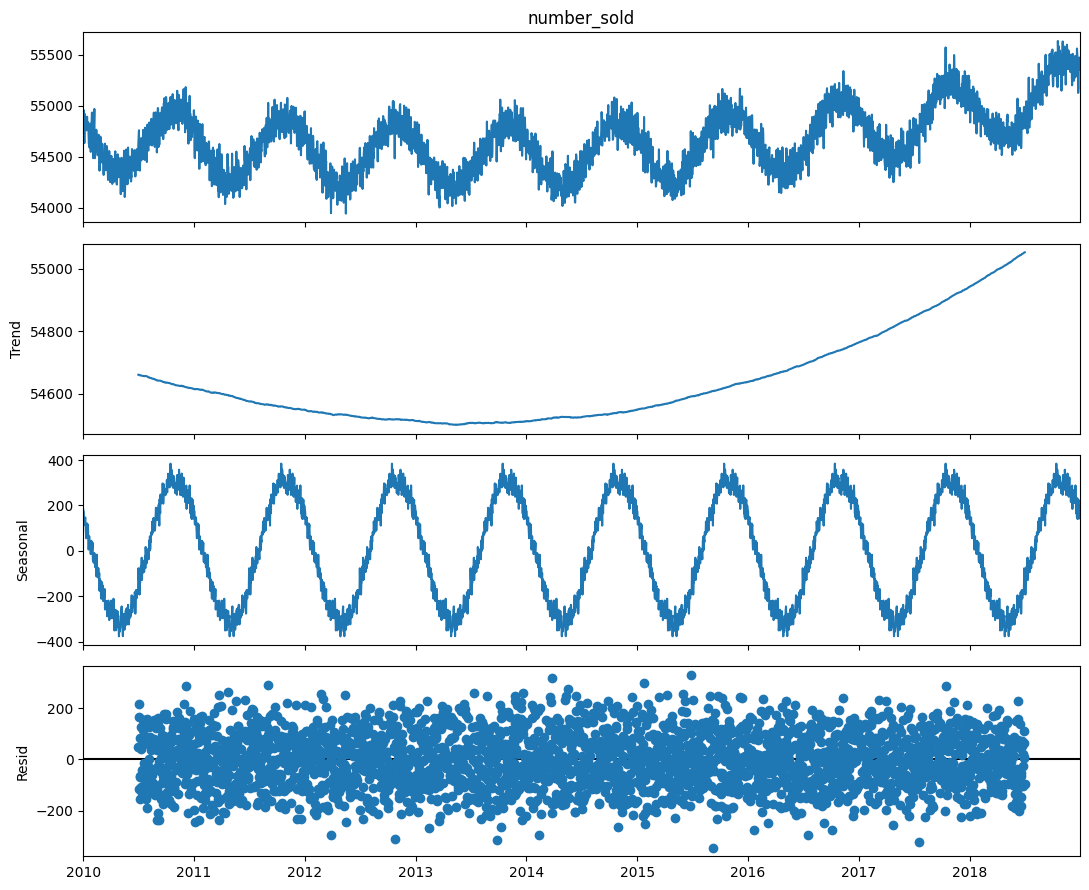

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9
decompose = seasonal_decompose(grouped_data.number_sold, period=365)
decompose.plot()

plt.show()

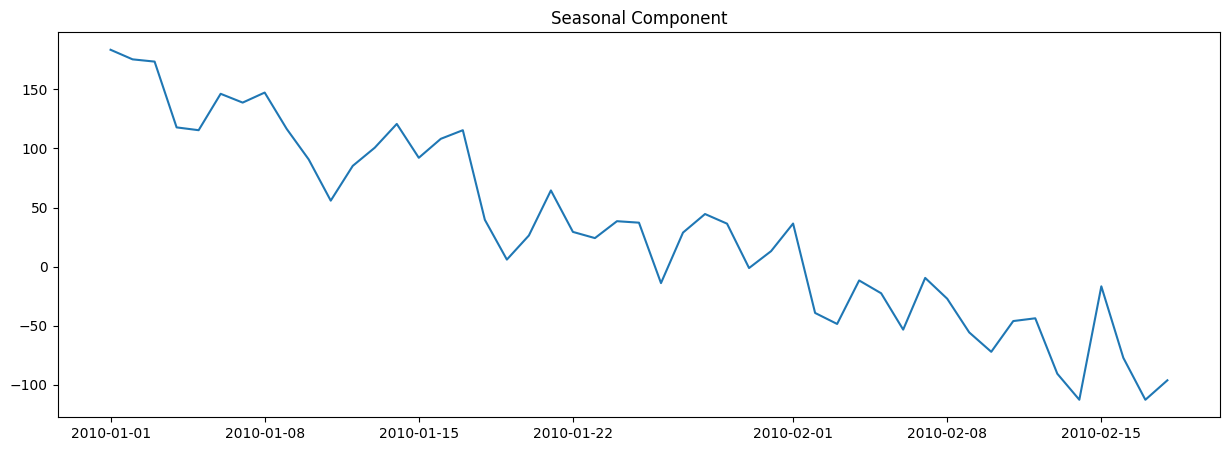

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(decompose.seasonal[:49])
plt.title('Seasonal Component')
plt.show()

Вывод по анализу с помощью seasonal_decompose: остатки выглядят как случайный шум без скрытых паттернов. Данные содержат выраженную годовую сезонность (period = 365), ярко выраженных зависимостей от дней недели нет

<Figure size 2000x600 with 0 Axes>

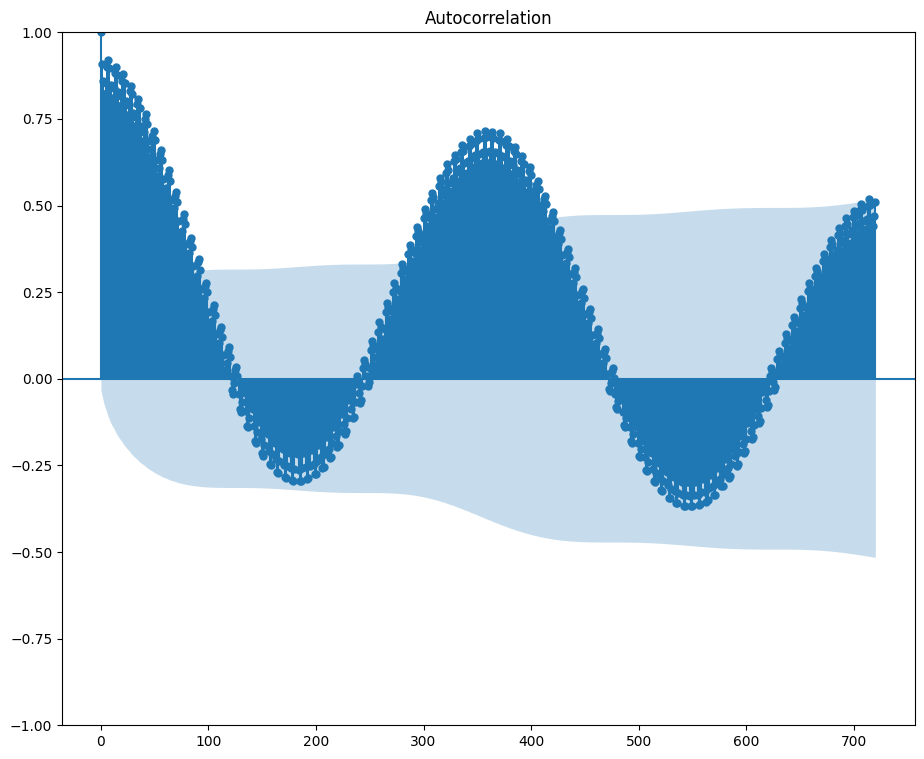

In [ ]:
import statsmodels.api as sm

plt.figure(figsize=(20, 6))
sm.graphics.tsa.plot_acf(grouped_data.values.squeeze(), lags=720)
plt.show()

По итогам анализа автокорреляции остается выраженный годичный цикл (лаг 365 дней)

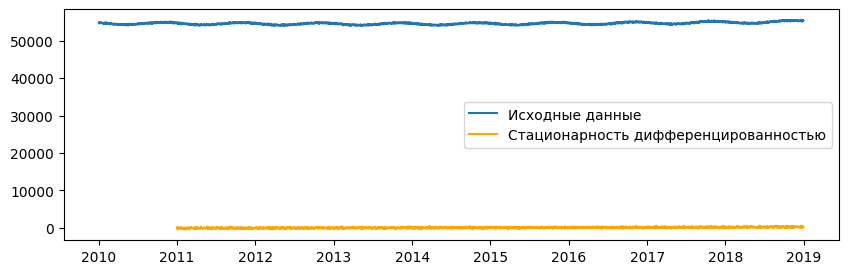

In [ ]:
# Дифференцирование для удаления тренда
differenced_data = grouped_data.diff(365).dropna()

plt.figure(figsize=(10, 3))
plt.plot(grouped_data, label='Исходные данные')
plt.plot(differenced_data, label='Стационарность дифференцированностью', color='orange')
plt.legend()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Тест Дики-Фуллера до дифференцирования
result = adfuller(grouped_data)
print(f"p-value до дифференцирования: {result[1]}")

# Дифференцирование
differenced_data = grouped_data.diff().dropna()

# Тест Дики-Фуллера после дифференцирования
result_after_diff = adfuller(differenced_data)
print(f"p-value после дифференцирования: {result_after_diff[1]}")

p-value до дифференцирования: 0.10779573173603202
p-value после дифференцирования: 3.8942498293818916e-10


Данные приведены к стационарному виду (стационарность подтверждает p-value < 0.05). Можно приступать к построению модели.

# 2. Использование SARIMA

In [ ]:
df = grouped_data.resample('M').sum()

df

<ipython-input-8-030e59f8085f>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = grouped_data.resample('M').sum()


,number_sold
Date,
2010-01-31,1698403
2010-02-28,1529750
2010-03-31,1688388
2010-04-30,1630998
2010-05-31,1685240
...,...
2018-08-31,1709901
2018-09-30,1660685
2018-10-31,1717400


                                SARIMAX Results                                 
Dep. Variable:              number_sold   No. Observations:                  108
Model:             SARIMAX(0, 2, 0, 12)   Log Likelihood                -953.590
Date:                  Sun, 24 Nov 2024   AIC                           1909.180
Time:                          20:28:11   BIC                           1911.610
Sample:                      01-31-2010   HQIC                          1910.157
                           - 12-31-2018                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.023e+08    1.9e+07     21.154      0.000    3.65e+08     4.4e+08
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1227.39
Prob(Q):                       

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


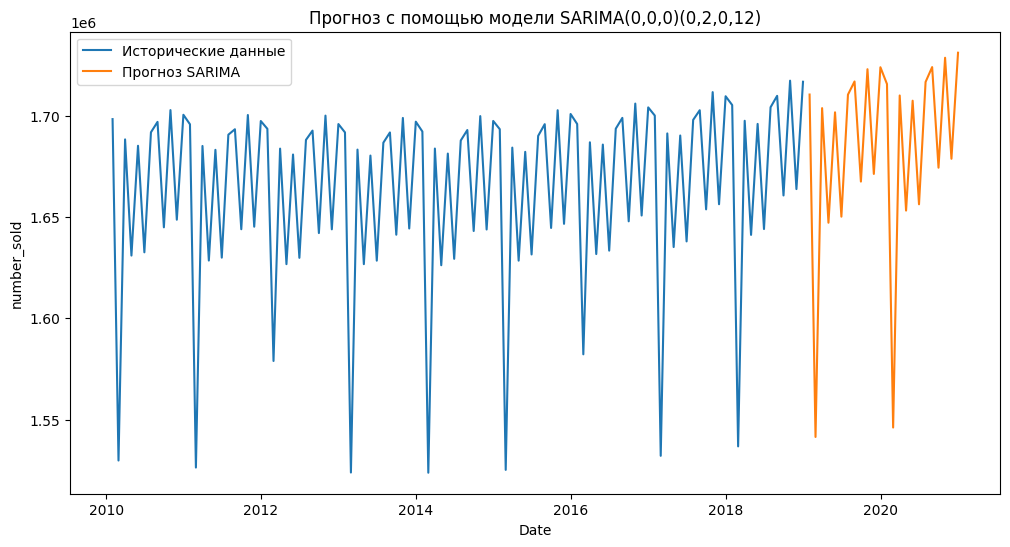

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns

y = df['number_sold']

# Создание модели SARIMA
model_sarima = SARIMAX(y, order=(0, 0, 0), seasonal_order=(0, 2, 0, 12)).fit()
print(model_sarima.summary())

# Прогноз на 24 месяца
forecast_sarima = model_sarima.predict(start=len(y), end=len(y)+23, typ='levels')
plt.figure(figsize=(12, 6))
sns.lineplot(data=y, label='Исторические данные')
sns.lineplot(data=forecast_sarima, label='Прогноз SARIMA')
plt.title('Прогноз с помощью модели SARIMA(0,0,0)(0,2,0,12)')
plt.show()

In [ ]:
#Тестирование нескольких параметров
orders = [(1, 1, 1), (0, 0, 0), (1, 1, 1)]
seasonal_orders = [(1, 1, 1, 12), (0, 1, 0, 12), (0, 2, 0, 12), (0, 3, 0, 12)]

aic_values = []
bic_values = []
models = []

for order in orders:
    for seasonal_order in seasonal_orders:
        try:
            model = SARIMAX(y, order=order, seasonal_order=seasonal_order).fit(disp=False)
            models.append((model, order, seasonal_order))
            aic_values.append(model.aic)
            bic_values.append(model.bic)
        except Exception as e:
            print(f'Ошибка: SARIMAX{order}x{seasonal_order} - Error: {e}')

# Check if any models were successfully fitted
if aic_values and bic_values:
    best_aic_model = models[np.argmin(aic_values)]
    best_bic_model = models[np.argmin(bic_values)]

    print(f'\nЛучшая по AIC: SARIMAX{best_aic_model[1]}x{best_aic_model[2]}')
    print(f'Лучшая по BIC: SARIMAX{best_bic_model[1]}x{best_bic_model[2]}')
else:
    print("Ошибка: Ни одну модель не удалось обучить.")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



Лучшая по AIC: SARIMAX(0, 0, 0)x(0, 2, 0, 12)
Лучшая по BIC: SARIMAX(0, 0, 0)x(0, 2, 0, 12)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Лучшие параметры определены как (0, 0, 0)(0, 2, 0, 12) - с двумя дифференциалами по сезонной составляющей

# Анализ остатков модели

In [ ]:
# Остатки модели
residuals = model_sarima.resid

print(residuals.describe())


count    1.080000e+02
mean     1.146354e+03
std      7.875955e+05
min     -1.701087e+06
25%     -7.325000e+01
50%      1.501500e+03
75%      2.536750e+03
max      1.702867e+06
dtype: float64


In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan
# Создаём exog с двумя колонками: константа и индекс
exog_for_test = np.column_stack((np.ones(len(residuals)), np.arange(len(residuals))))

# Тест Бройша-Пагана
bp_test = het_breuschpagan(residuals, exog_for_test)

# Оформляем результаты теста
labels = ['LM Stat', 'LM p-value', 'F-stat', 'F p-value']
bp_test_results = dict(zip(labels, bp_test))

print("Breusch-Pagan test results:")
for key, value in bp_test_results.items():
    print(f"{key}: {value}")

# Интерпретация результатов
if bp_test_results['F p-value'] > 0.05:
    print("Гомоскедастичность подтверждена (остатки имеют равномерную дисперсию).")
else:
    print("Гомоскедастичность отвергнута (остатки имеют неоднородную дисперсию).")




Breusch-Pagan test results:
LM Stat: 55.62485211624479
LM p-value: 8.770778187984347e-14
F-stat: 112.5769484681634
F p-value: 2.3486127868366765e-18
Гомоскедастичность отвергнута (остатки имеют неоднородную дисперсию).


In [ ]:
from scipy.stats import shapiro

# Тест Шапиро-Уилка
shapiro_test = shapiro(residuals)
print(f"\nShapiro-Wilk test results:\nW: {shapiro_test[0]:.4f}, p-value: {shapiro_test[1]:.14f}")


Shapiro-Wilk test results:
W: 0.6616, p-value: 0.00000000000002


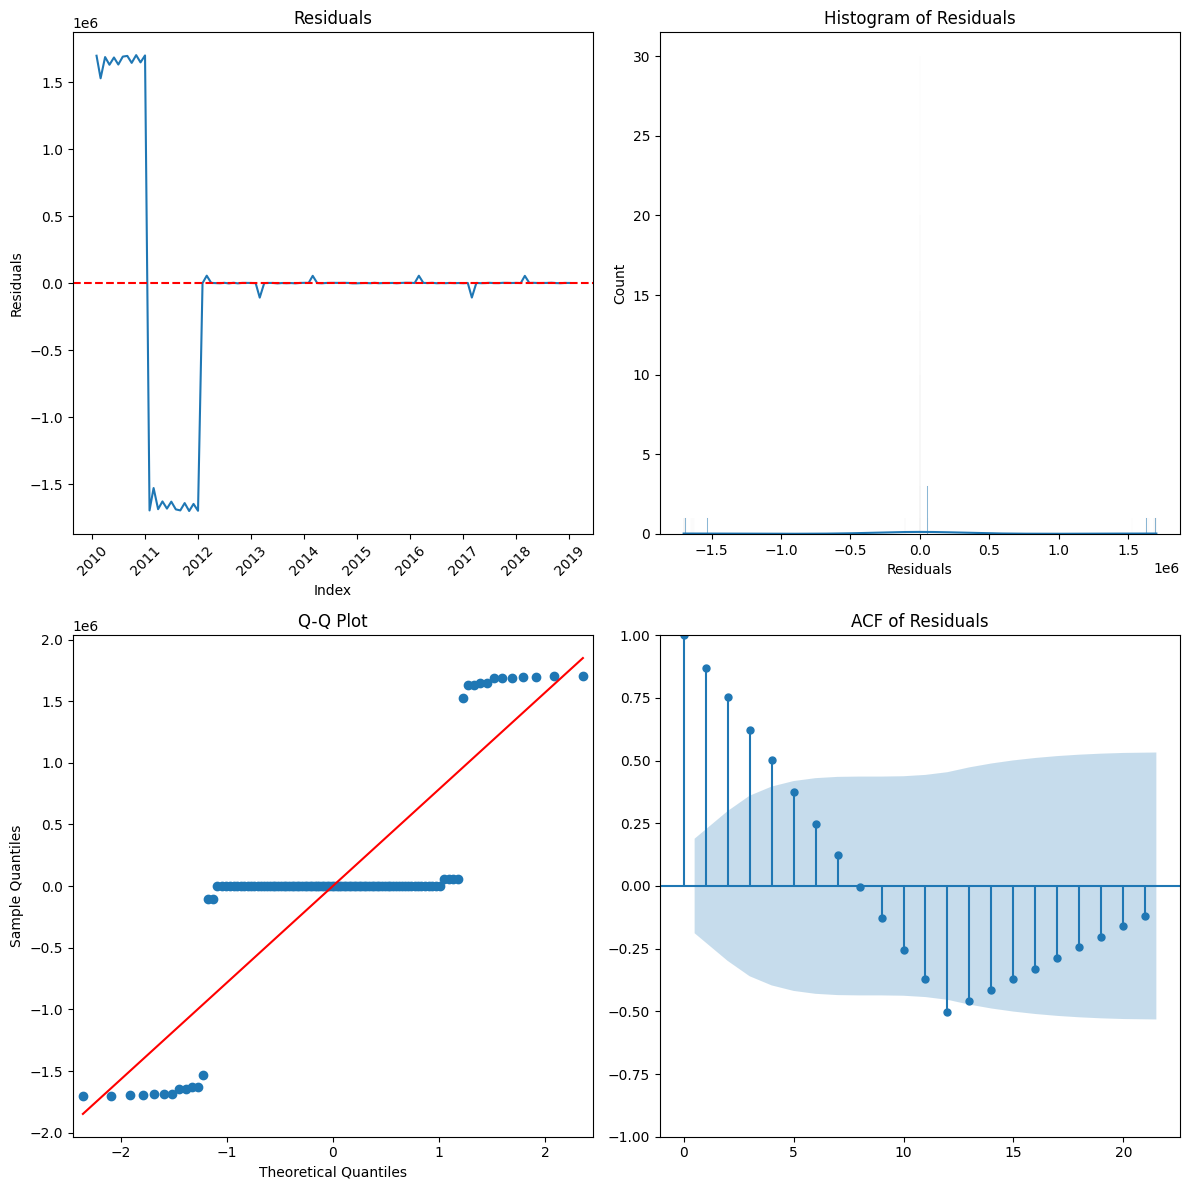

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf


# 1. График остатков
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals')
plt.xlabel('Index')
plt.xticks(rotation=45)
plt.ylabel('Residuals')

# 2. Гистограмма остатков
plt.subplot(2, 2, 2)
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')

# 3. Q-Q plot для проверки нормальности
plt.subplot(2, 2, 3)
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title('Q-Q Plot')

# 4. ACF Plot для проверки автокорреляции остатков
plt.subplot(2, 2, 4)
plot_acf(residuals, ax=plt.gca())
plt.title('ACF of Residuals')

plt.tight_layout()
plt.show()


В ходе анализа остатков обнаружены проблемы выбросов и низкой автокорреляции, не решаемые удалением выбросов, логарифмированием и подбором параметров; Для дальнейшей интерпритации работы модели с тестовыми данными надо иметь в виду данные ограничения.

# Оценка качества предсказаний

In [ ]:
TEST_DATA = '/content/drive/MyDrive/временные ряды/test.csv'

In [ ]:
data_test = pd.read_csv(TEST_DATA)
data_test = data_test.groupby('Date')['number_sold'].sum().reset_index()
data_test['Date'] = pd.to_datetime(data_test['Date'])
data_test.set_index('Date', inplace = True)
data_test = data_test.resample('M').sum()
data_test

<ipython-input-22-9eeb6e235caf>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_test = data_test.resample('M').sum()


,number_sold
Date,
2019-01-31,1713370
2019-02-28,1543318
2019-03-31,1704861
2019-04-30,1647955
2019-05-31,1704229
2019-06-30,1652183
2019-07-31,1712031
2019-08-31,1717806
2019-09-30,1667298


In [ ]:
y_pred_test = model_sarima.forecast(steps=len(data_test))


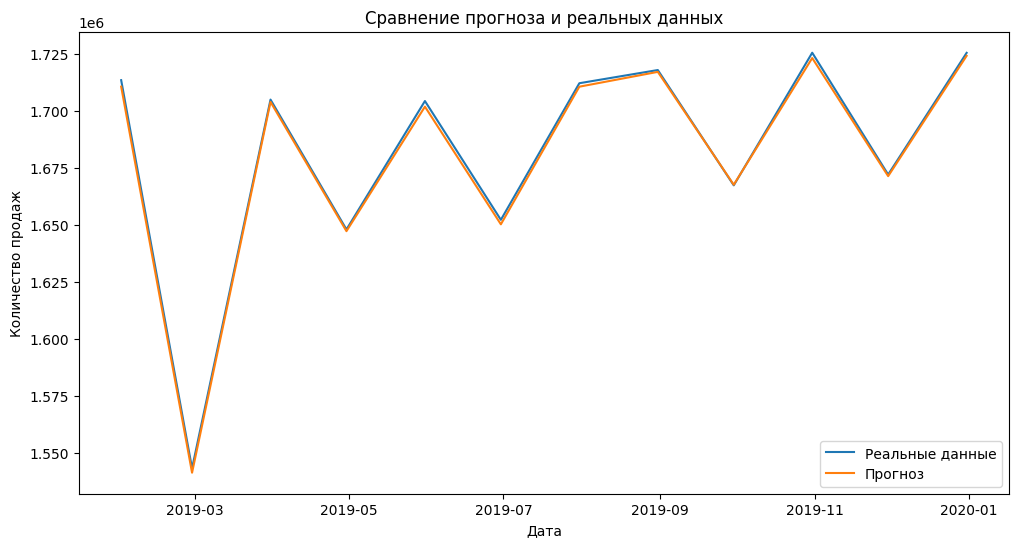

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(x=data_test.index, y=data_test['number_sold'], label='Реальные данные')
sns.lineplot(x=y_pred_test.index, y=y_pred_test, label='Прогноз')
plt.title('Сравнение прогноза и реальных данных')
plt.xlabel('Дата')
plt.ylabel('Количество продаж')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score


# Метрики
mape = mean_absolute_percentage_error(data_test['number_sold'], y_pred_test)
rmse = mean_squared_error(data_test['number_sold'], y_pred_test, squared=False)
r2 = r2_score(data_test['number_sold'], y_pred_test)

print(f"MAPE: {mape:.2%}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.3f}")


MAPE: 0.09%
RMSE: 1680.26
R^2: 0.999


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Предсказание с SARIMA получилось достаточно точным